In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from tqdm import tqdm
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import log2
tqdm.pandas()
from surprise import NMF
from sklearn.utils import resample
import pickle

In [2]:
np.random.seed(42)

In [3]:
# Load and filter data
interactions = pd.read_pickle('../Pickle/interactions.pkl')
imputed = pd.read_pickle('../Pickle/imputed_ratings.pkl')
interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  
books_list = []
with open('../Pickle/books.pkl', 'rb') as file:
    while True:
        try:
            books_list.append(pickle.load(file))
        except EOFError:
            break
books = pd.concat(books_list, ignore_index=True).drop_duplicates(subset='title', keep='first')

In [4]:
interactions = interactions[interactions['rating'] != 0]
frames = [interactions, imputed]
interactions = pd.concat(frames)

In [5]:
def split_data_with_single_interactions(df):
    # Identify users and books that appear only once in the dataset
    user_counts = df['user_id'].value_counts()
    book_counts = df['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = df[
        df['user_id'].isin(user_counts[user_counts == 1].index) | 
        df['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = df[~df.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42, stratify=remaining_interactions['rating'])

    # Add the single interactions to the training set
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)


    return train_df, test_df

train_df, test_df = split_data_with_single_interactions(interactions)

In [6]:
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

MAX_TARGET_SIZE = int(0.75 * majority_count)

modified_dfs = []

# Perform upsampling with slight noise addition for each class
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]

    if count >= MAX_TARGET_SIZE:
        balanced_df = class_df.copy()
    else:
        balanced_df = resample(class_df,
                               replace=True,
                               n_samples=MAX_TARGET_SIZE,
                               random_state=42)

        # Add random noise to the ratings
        balanced_df['rating'] = balanced_df['rating'] + np.random.uniform(-0.1, 0.1, size=balanced_df.shape[0])
        # Ensure ratings are within the valid range (e.g., between 1 and 5)
        balanced_df['rating'] = balanced_df['rating'].clip(1, 5)

    modified_dfs.append(balanced_df)


balanced_train = pd.concat(modified_dfs, ignore_index=True)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


def denormalize_rating(log_scaled_ratings, min_rating):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [8]:
train_df, test_df, min_rating = normalise_ratings(train_df, test_df)

In [9]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

In [ ]:
# Define the parameter grid
param_grid = { 
    'n_factors': [10, 20, 50],  
    'n_epochs': [40, 80, 160, 200],  
    'reg_pu': [0.01, 0.1],  # Regularization for user factors
    'reg_qi': [0.01, 0.1],  # Regularization for item factors
    'lr_bu': [0.01, 0.1],  # Learning rate for user bias
    'lr_bi': [0.01, 0.1],  # Learning rate for item bias
    'random_state': [42]
}

gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=2)

gs.fit(train_data)

best_params = gs.best_params['rmse']
best_nmf = NMF(**best_params, verbose = True)

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best MAE: {gs.best_score['mae']:.4f}")


print(f"Best Parameters: {best_params}")

Best RMSE: 0.2227
Best MAE: 0.1557
Best Parameters: {'n_factors': 50, 'n_epochs': 200, 'reg_pu': 0.01, 'reg_qi': 0.01, 'lr_bu': 0.01, 'lr_bi': 0.01, 'random_state': 42}


In [11]:
trainset = train_data.build_full_trainset()
testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]
best_nmf.fit(trainset)
predictions = best_nmf.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [12]:
from surprise import accuracy
test_rmse = accuracy.rmse(predictions)
test_mae = accuracy.mae(predictions)

RMSE: 0.2591
MAE:  0.1953


In [13]:
import joblib
joblib.dump(best_nmf, '../Pickle/best_nmf_model.pkl')

['../Pickle/best_nmf_model.pkl']

In [20]:
predictions = [prediction for prediction in predictions if not prediction.details.get('was_impossible', False)]


In [22]:
def evaluate_model(predictions, min_rating, k, threshold, item_popularity, num_users):
    # Denormalize predictions
    denormalized_predictions = [
        (uid, iid, true_r * (5 - min_rating) + min_rating, est * (5 - min_rating) + min_rating, details)
        for (uid, iid, true_r, est, details) in predictions
    ]

    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []
    ndcgs = []
    map_scores = []
    mrr_scores = []  # Add MRR scores
    novelty_scores = []
    hit_rate_scores = []
    recommended_relevant_items = set()  # For relevant item coverage

    relevant_items = set(iid for _, iid, true_r, _, _ in denormalized_predictions if true_r >= threshold)

    for user_id, user_ratings in user_est_true.items():
        # Sort predictions by estimated value
        user_ratings_sorted = sorted(user_ratings, key=lambda x: x[1], reverse=True)
        top_k = user_ratings_sorted[:k]

        top_k_items = [iid for iid, _, _ in top_k]

        # Precision and Recall
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)

        precision = n_rel_and_rec_k / k if k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        # NDCG@k
        dcg = sum(
            (true_r >= threshold) / np.log2(idx + 2)
            for idx, (_, _, true_r) in enumerate(top_k)
        )
        idcg = sum(
            1.0 / np.log2(idx + 2) for idx in range(min(n_rel, k))
        )
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)

        # MAP@k
        hits = 0
        sum_precisions = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                hits += 1
                sum_precisions += hits / (idx + 1)
        ap = sum_precisions / min(n_rel, k) if n_rel != 0 else 0
        map_scores.append(ap)

        # MRR Calculation: Find the reciprocal of the rank of the first relevant item
        first_relevant_rank = None
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                first_relevant_rank = idx + 1  # Rank is 1-based
                break

        if first_relevant_rank is not None:
            mrr_scores.append(1 / first_relevant_rank)
        else:
            mrr_scores.append(0)

        # Novelty (1 - average popularity of the recommended items)
        novelty = np.mean([1 - (item_popularity.get(iid, 1) / num_users) for iid in top_k_items])
        novelty_scores.append(novelty)

        # Hit Rate (proportion of users who have at least one relevant item in top_k)
        hit_rate = 1 if n_rel_and_rec_k > 0 else 0
        hit_rate_scores.append(hit_rate)

        # For Relevant Item Coverage@k
        recommended_relevant_items.update([iid for iid, est, true_r in top_k if true_r >= threshold])

    # User Coverage@k (the proportion of users with at least one relevant recommendation)
    user_coverage = sum(1 for user_ratings in user_est_true.values() if any(true_r >= threshold for _, _, true_r in user_ratings)) / len(user_est_true)

    # Return results
    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(map_scores),
        np.mean(mrr_scores), 
        np.mean(novelty_scores),
        np.mean(hit_rate_scores),
        user_coverage
    )


k = 5
threshold = 4  # Relevance threshold
item_popularity = test_df['book_id'].value_counts().to_dict()
num_users = test_df['user_id'].nunique()

# Compute metrics
precision, recall, ndcg, map_score, mrr, novelty, hit_rate, user_coverage = evaluate_model(
    predictions, min_rating=min_rating, k=k, threshold=threshold, item_popularity=item_popularity, num_users=num_users
)

# Print results
print(f'Precision@{k}: {precision:.4f}')
print(f'Recall@{k}: {recall:.4f}')
print(f'nDCG@{k}: {ndcg:.4f}')
print(f'MAP@{k}: {map_score:.4f}')
print(f'MRR@{k}: {mrr:.4f}')
print(f'Novelty: {novelty:.4f}')
print(f'Hit Rate: {hit_rate:.4f}')
print(f'User Coverage: {user_coverage:.4f}')


Precision@5: 0.7920
Recall@5: 0.4972
nDCG@5: 0.9936
MAP@5: 0.9905
MRR@5: 0.9957
Novelty: 0.9930
Hit Rate: 1.0000
User Coverage: 1.0000


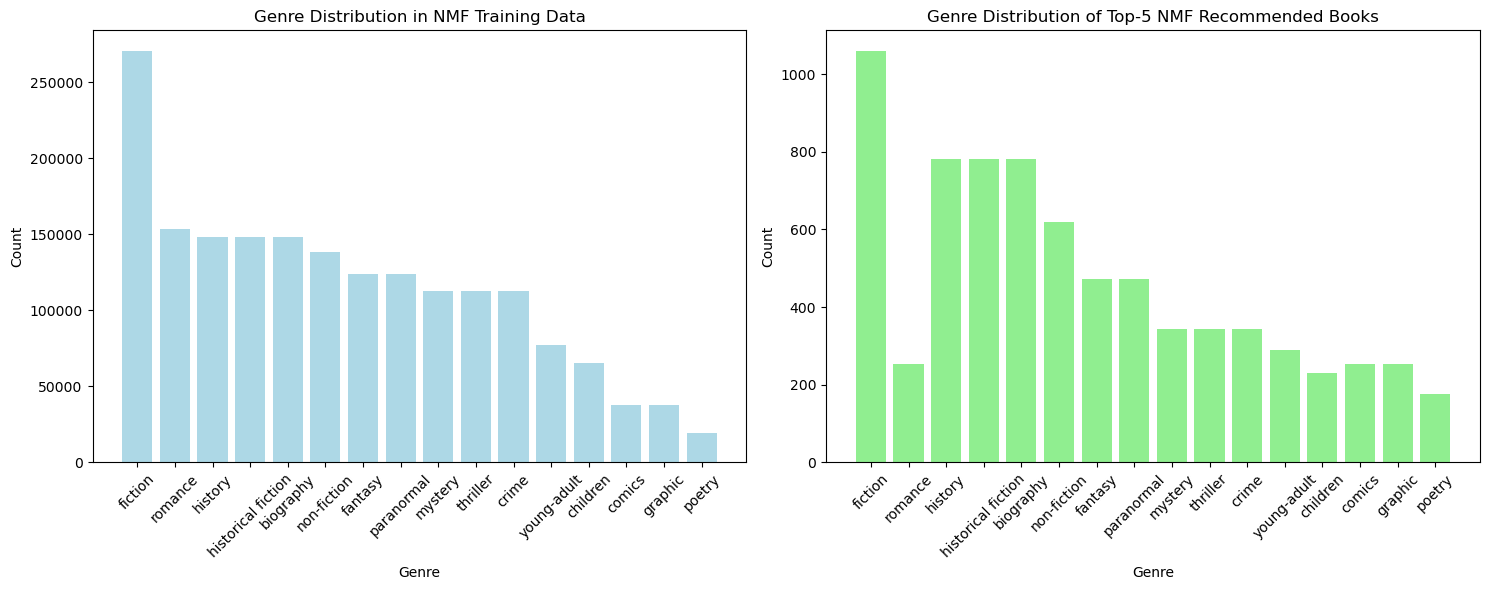

Overlap of genres: 7458
Total genres in training data (counts): 1830163
Total genres in top-5 recommendations (counts): 7458
Total unique genres in training data: 16
Total unique genres in top-5 recommendations: 16


In [29]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

user_predictions = {}

# Loop through all predictions (user-item pairs and their predicted ratings)
for prediction in predictions:
    uid = prediction.uid
    iid = prediction.iid
    predicted_rating = prediction.est

    if uid not in user_predictions:
        user_predictions[uid] = []
    user_predictions[uid].append((iid, predicted_rating))

top_k = 5  # Choose the value of k, e.g., top-5 recommendations
top_k_predictions = {}

for uid, items in user_predictions.items():
    # Sort items by predicted ratings in descending order and get top-k
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)[:top_k]
    top_k_predictions[uid] = sorted_items

# Genres for top-k recommended books
predicted_book_genres = []

# Loop through top-k recommendations
for uid, top_items in top_k_predictions.items():
    for iid, predicted_rating in top_items:
        book = books[books['book_id'] == iid]  # Match book ID to the books dataset
        if not book.empty:
            genres = book.iloc[0]['filtered_genres'].split(',')  # assuming comma-separated
            predicted_book_genres.extend([genre.strip() for genre in genres])

# Count genres in top-k recommendations
predicted_genre_counts = Counter(predicted_book_genres)

# Get genre counts from the training data
genre_list = []
for genres in books['filtered_genres']:
    genre_list.extend([genre.strip() for genre in genres.split(',')])

train_genre_counts_series = pd.Series(genre_list).value_counts()
train_genre_counts_df = train_genre_counts_series.reset_index()
train_genre_counts_df.columns = ['Genre', 'Count']

# Align genres for both plots by using the training genre order
genre_order = train_genre_counts_df['Genre'].tolist()

# Reindex predicted genre counts to match training genre order
predicted_genre_counts_ordered = [predicted_genre_counts.get(genre, 0) for genre in genre_order]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for training data
ax[0].bar(genre_order, train_genre_counts_df['Count'], color='lightblue')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('Count')
ax[0].set_title('Genre Distribution in NMF Training Data')
ax[0].tick_params(axis='x', rotation=45)

# Plot for predicted (top-k) data
ax[1].bar(genre_order, predicted_genre_counts_ordered, color='lightgreen')
ax[1].set_xlabel('Genre')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Genre Distribution of Top-{top_k} NMF Recommended Books')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Overlap calculation
overlap = sum(
    min(train_genre_counts_series.get(genre, 0), predicted_genre_counts.get(genre, 0)) 
    for genre in train_genre_counts_series.index
)
total_train_genres = train_genre_counts_series.sum()
total_predicted_genres = sum(predicted_genre_counts.values())

# Count total unique genres
unique_train_genres = train_genre_counts_series.index.nunique()
unique_predicted_genres = len(predicted_genre_counts)

print(f"Overlap of genres: {overlap}")
print(f"Total genres in training data (counts): {total_train_genres}")
print(f"Total genres in top-{top_k} recommendations (counts): {total_predicted_genres}")
print(f"Total unique genres in training data: {unique_train_genres}")
print(f"Total unique genres in top-{top_k} recommendations: {unique_predicted_genres}")

In [24]:
est_ratings = np.array([pred.est for pred in predictions], dtype=float)
true_ratings = np.array([pred.r_ui for pred in predictions], dtype=float)
true_ratings = denormalize_rating(true_ratings, min_rating)
est_ratings = denormalize_rating(est_ratings, min_rating)

In [25]:
true_ratings.mean()

4.605856324469782

In [26]:
est_ratings.mean()

4.414729027276557

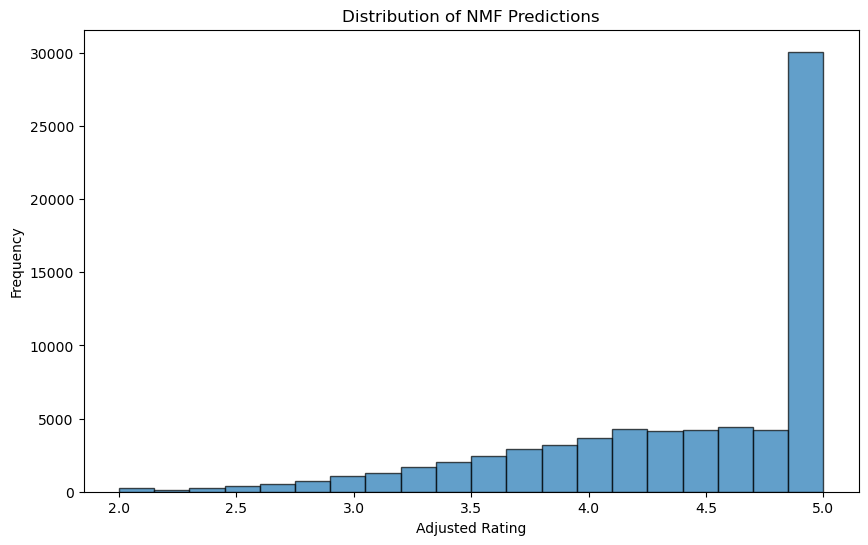

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(est_ratings, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of NMF Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()